Code for delta hedged initialised short straddle with automated adjustments 

Made by Ayush Agarwal ECE24 IIT BHU 

In [232]:
# FINANCE RELATED LIBRARIES 
# !pip install py_vollib
# !pip install yfinance
# !pip install nsepy

In [233]:
# GARBAGE CODE , WAS SUPPOSED TO ADD STOCKS DATA AUTOMATICALLY 
# # Stock options (Similarly for index options, set index = True)
# from datetime import date
# from nsepy import get_history

# nifty_opt = get_history(symbol="NIFTY",
#                         start=date(2021,12,3),
#                         end=date(2021,12,27),
#                         index=True,
#                         option_type='CE',
#                         strike_price=17000,
#                         expiry_date=date(2015,12,28))
# print(nifty_opt)

In [234]:
# IMPORTING THE IMPORTANT LIBRARIES 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import scipy.stats as ss
import py_vollib.black_scholes.greeks.analytical as derivatives
import math

In [235]:
# READING THE DATA 
# df = pd.read_excel('/content/adjusting_short_strangle.xlsx')
df = pd.read_excel('/content/adjusting_short_strangle - Copy.xlsx')
print(df.head())
print(df.describe())
# stddev of stocks is 381.5

        Date  Stock Price  Strike Price       CE      PE
0 2021-05-28  35345.64844         35000  1394.65  940.00
1 2021-05-31  35097.44922         35000  1197.95  886.00
2 2021-06-01  39000.00000         35000  1291.90  682.35
3 2021-06-02  39000.00000         35000  1099.30  747.50
4 2021-06-03  39000.00000         35000  1163.20  486.50
        Stock Price  Strike Price           CE          PE
count     19.000000          19.0    19.000000   19.000000
mean   34602.097245       35000.0   768.915789  540.178947
std     2140.557322           0.0   410.389117  190.138984
min    33000.000000       35000.0    99.000000  187.750000
25%    33000.000000       35000.0   442.475000  441.250000
50%    33400.000000       35000.0   779.350000  497.450000
75%    35091.173830       35000.0  1131.250000  667.850000
max    39000.000000       35000.0  1394.650000  940.000000


In [236]:
# CONVERTING DATES TO PANDAS FORM SO THAT CALCULATING DIFFERENCE IS EASIER 
# df['Dates'] = pd.to_datetime(df['Date'],format='%d%m%Y')
df['Date'] = pd.to_datetime(df['Date'])
print(df)

         Date  Stock Price  Strike Price       CE      PE
0  2021-05-28  35345.64844         35000  1394.65  940.00
1  2021-05-31  35097.44922         35000  1197.95  886.00
2  2021-06-01  39000.00000         35000  1291.90  682.35
3  2021-06-02  39000.00000         35000  1099.30  747.50
4  2021-06-03  39000.00000         35000  1163.20  486.50
5  2021-06-04  35000.00000         35000  1238.90  476.75
6  2021-06-07  33000.00000         35000  1052.00  497.45
7  2021-06-08  33000.00000         35000  1007.10  403.85
8  2021-06-09  33000.00000         35000   779.35  521.80
9  2021-06-10  33000.00000         35000   630.75  653.35
10 2021-06-11  33000.00000         35000   821.65  430.00
11 2021-06-14  33000.00000         35000   574.70  517.20
12 2021-06-15  33100.00000         35000   544.95  452.50
13 2021-06-16  33100.00000         35000   599.35  340.15
14 2021-06-17  33400.00000         35000   340.00  515.00
15 2021-06-18  33400.00000         35000   265.65  490.00
16 2021-06-21 

In [237]:
# CALCULATING DELTA USING THE BLACK SCHOLES 
sigma = 11.34 #volatility
r = 0.06 #risk free rate
df['delta_CE'] = df['CE']
df['delta_PE'] = df['PE']

for i in range(0,len(df)):
  df['delta_CE'][i] = derivatives.delta('c', df['CE'][i],df['Strike Price'][i],((df['Date'][len(df)-1]-df['Date'][i])/np.timedelta64(1,'Y')), r, sigma)
  df['delta_PE'][i] = derivatives.delta('p', df['PE'][i],df['Strike Price'][i],((df['Date'][len(df)-1]-df['Date'][i])/np.timedelta64(1,'Y')), r, sigma)
  

print(df.head())



        Date  Stock Price  Strike Price       CE      PE  delta_CE  delta_PE
0 2021-05-28  35345.64844         35000  1394.65  940.00  0.673303 -0.374993
1 2021-05-31  35097.44922         35000  1197.95  886.00  0.594158 -0.447393
2 2021-06-01  39000.00000         35000  1291.90  682.35  0.582161 -0.508748
3 2021-06-02  39000.00000         35000  1099.30  747.50  0.535114 -0.521418
4 2021-06-03  39000.00000         35000  1163.20  486.50  0.518026 -0.611524


In [238]:
# CODE TO FIND NUMBER OF SOLD CALLS REQUIRED FOR EXACT DELTA HEDGING THE PORTFOLIO 
# NOTE THAT WE WONT EXACT DELTA HEDGE THE ORTFOLIO SINCE IT WOULD BE COSTLY TO DO SO 

# Selling a put means that our portfolio delta increases (is positive) 
# Selling a call means our portfolio delta decreases (is negative) 
put_lot_size = 10
df['put_lot_size'] = pd.Series(put_lot_size, index=range(len(df)))
# print(df.head())
df['call_lot_size'] = (round((df['put_lot_size']*df['delta_PE'])/((-1)*df['delta_CE'])))
df['call_lot_size'][18] = df['call_lot_size'][17]  ###################################################
# df['call_lot_diff'][18] = df['call_lot_diff'][17]
df['call_lot_size'] = df['call_lot_size'].astype(int)

df['call_lot_diff'] = df['call_lot_size']
df['call_lot_diff'][0] = 0
for i in range(1,len(df)):
  df['call_lot_diff'][i] = df['call_lot_size'][i] - df['call_lot_size'][i-1]

print(df)

         Date  Stock Price  Strike Price       CE      PE      delta_CE  \
0  2021-05-28  35345.64844         35000  1394.65  940.00  6.733028e-01   
1  2021-05-31  35097.44922         35000  1197.95  886.00  5.941578e-01   
2  2021-06-01  39000.00000         35000  1291.90  682.35  5.821610e-01   
3  2021-06-02  39000.00000         35000  1099.30  747.50  5.351143e-01   
4  2021-06-03  39000.00000         35000  1163.20  486.50  5.180256e-01   
5  2021-06-04  35000.00000         35000  1238.90  476.75  5.010463e-01   
6  2021-06-07  33000.00000         35000  1052.00  497.45  3.863820e-01   
7  2021-06-08  33000.00000         35000  1007.10  403.85  3.468325e-01   
8  2021-06-09  33000.00000         35000   779.35  521.80  2.734041e-01   
9  2021-06-10  33000.00000         35000   630.75  653.35  2.099658e-01   
10 2021-06-11  33000.00000         35000   821.65  430.00  2.128521e-01   
11 2021-06-14  33000.00000         35000   574.70  517.20  7.815882e-02   
12 2021-06-15  33100.0000

In [239]:
# LIBRARY FOR P/L DIAGRAMS OF OPTIONS 
# !pip install opstrat 

number puts 10
number calls 6
Stock Price : 35345
ubp : 37961.316666666666
lbp : 33223.21


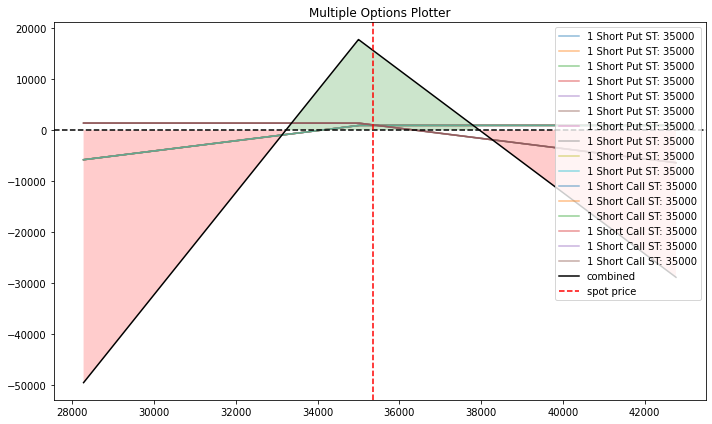

Stock Price : 35097
ubp : 37961.316666666666
lbp : 33223.21


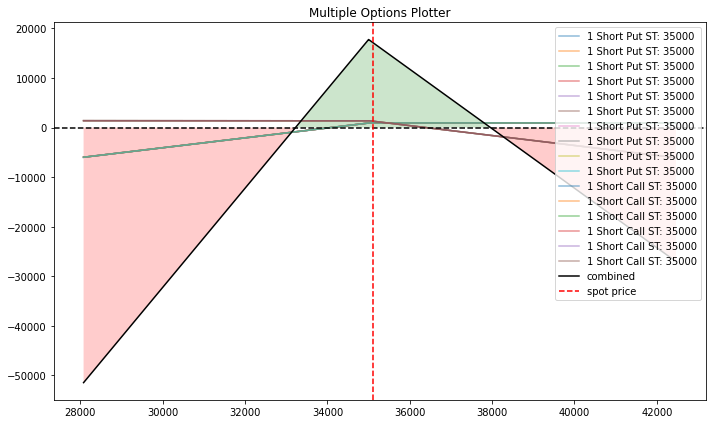

Stock Price : 39000
ubp : 37961.316666666666
lbp : 33223.21


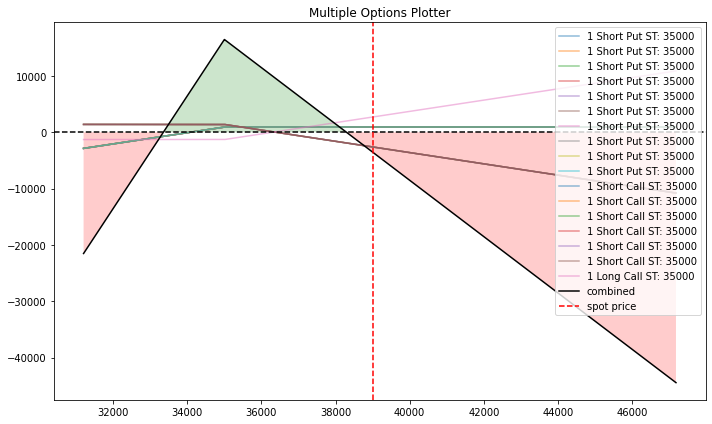

Stock Price : 39000
ubp : 38295.2
lbp : 33352.4


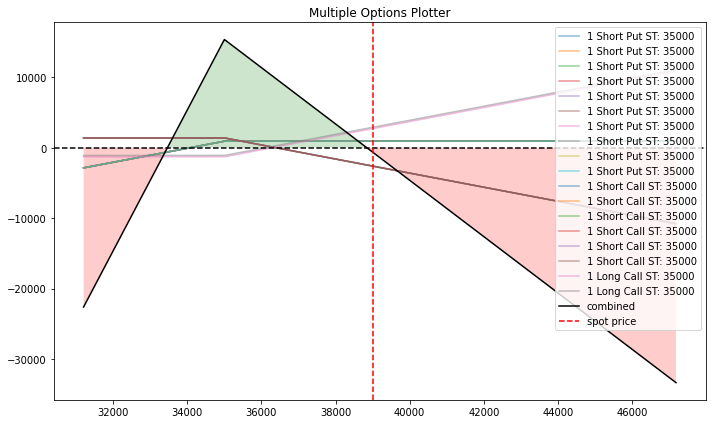

Stock Price : 39000
ubp : 38844.175
lbp : 33462.33


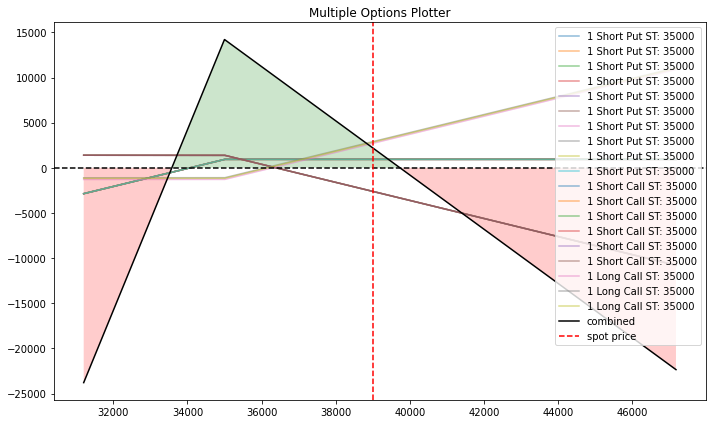

Stock Price : 35000
ubp : 39737.833333333336
lbp : 33578.65


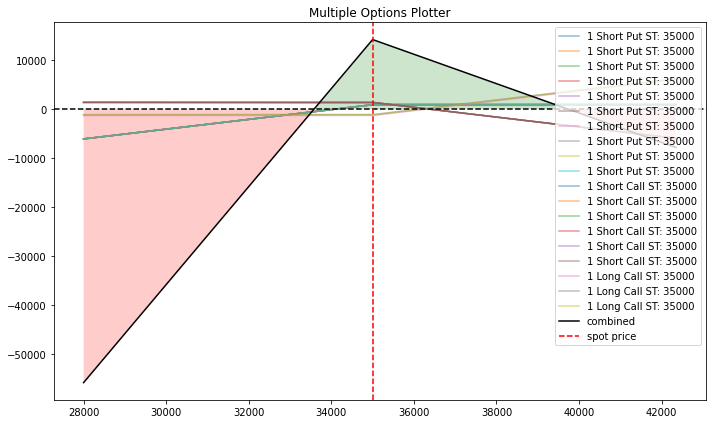

Stock Price : 33000
ubp : 39737.833333333336
lbp : 33578.65


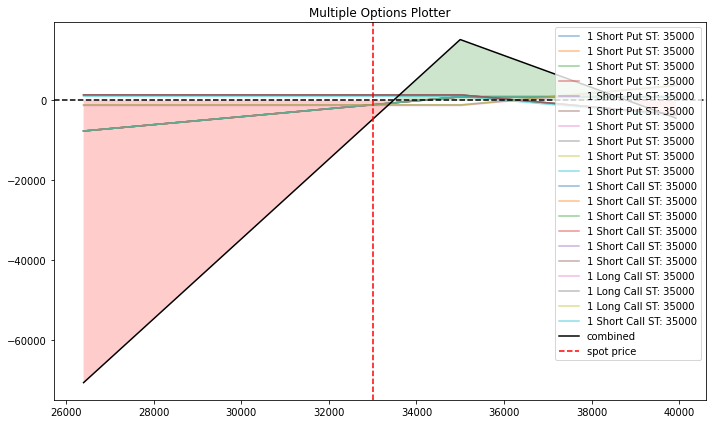

Stock Price : 33000
ubp : 38816.375
lbp : 33473.45


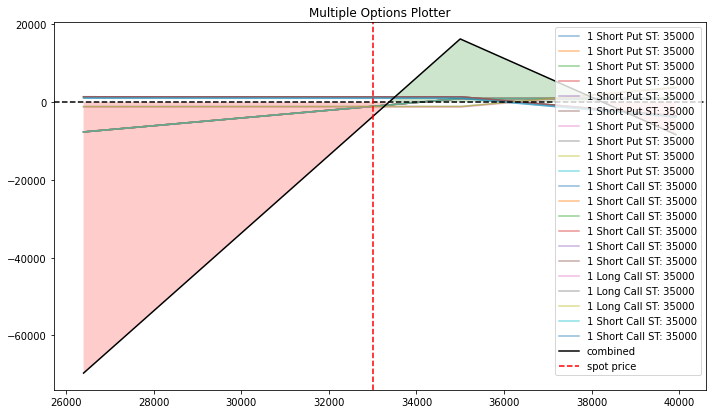

Stock Price : 33000
ubp : 38254.52
lbp : 33372.74


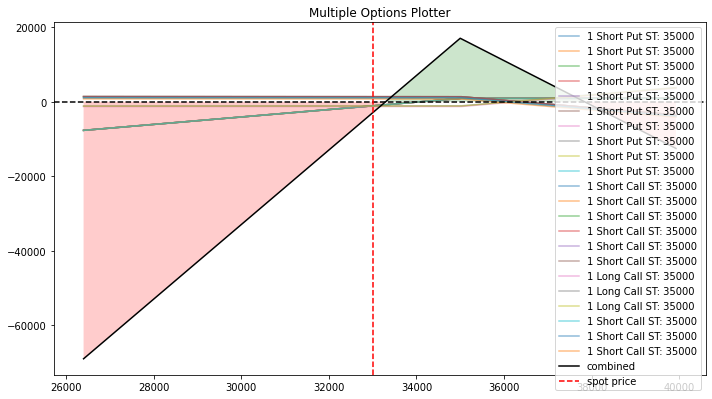

Stock Price : 33000
ubp : 37841.99166666667
lbp : 33294.805


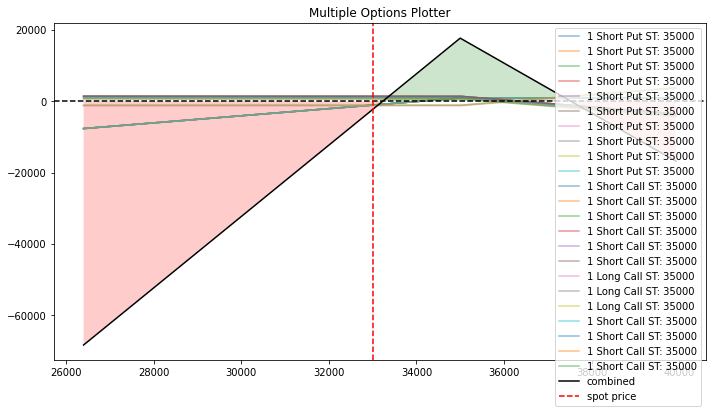

Stock Price : 33000
ubp : 37526.1
lbp : 33231.73


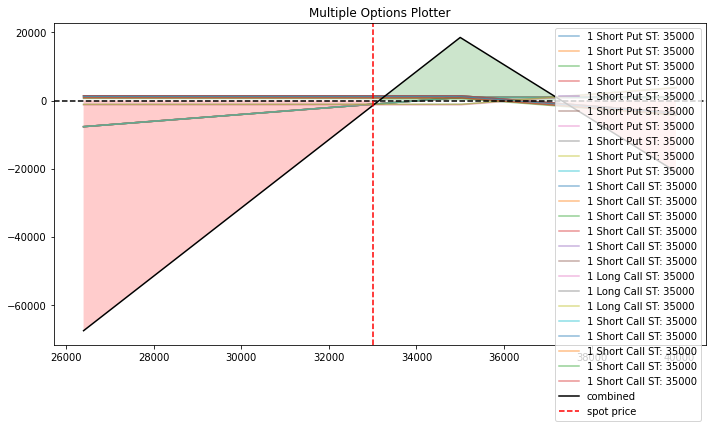

Stock Price : 33000
ubp : 37313.04375
lbp : 33149.565


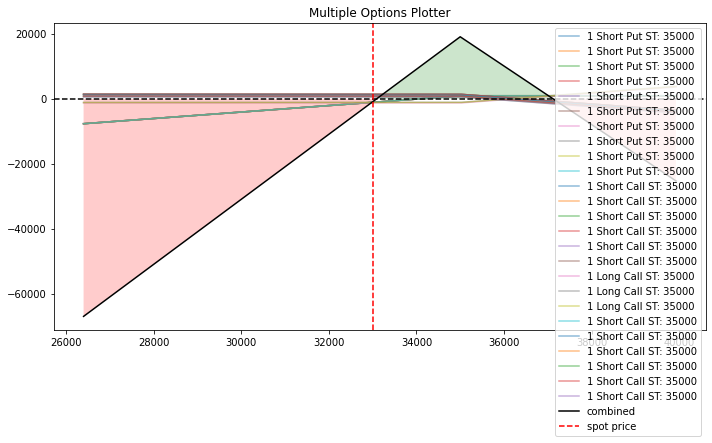

Stock Price : 33100
ubp : 37119.89444444444
lbp : 33092.095


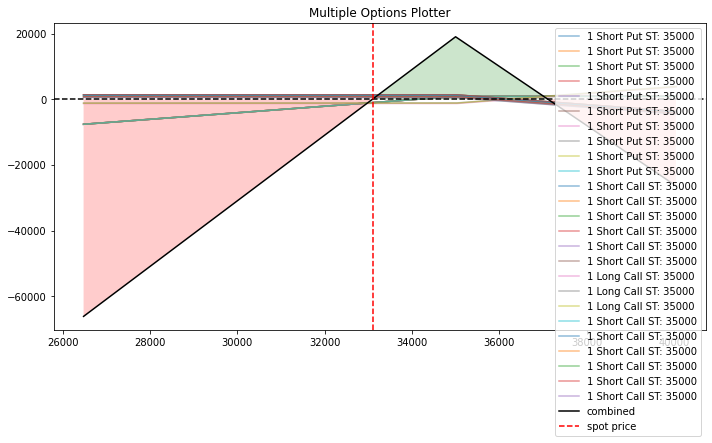

Stock Price : 33100
ubp : 37119.89444444444
lbp : 33092.095


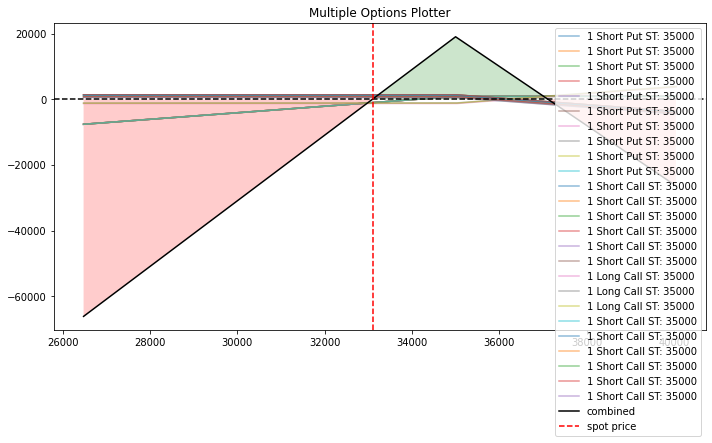

Stock Price : 33400
ubp : 37119.89444444444
lbp : 33092.095


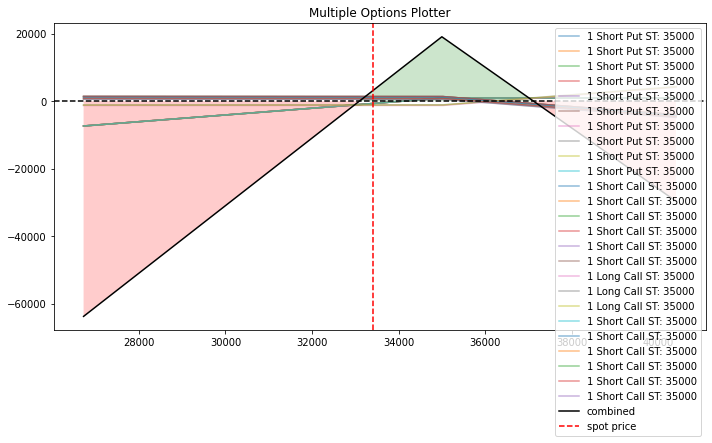

Stock Price : 33400
ubp : 37119.89444444444
lbp : 33092.095


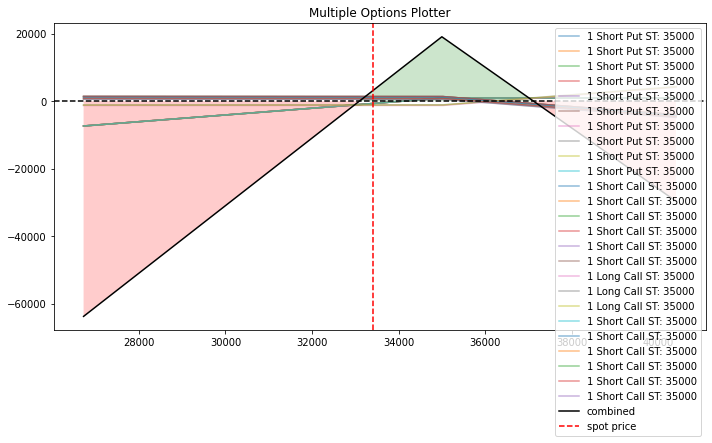

Stock Price : 34000
ubp : 37119.89444444444
lbp : 33092.095


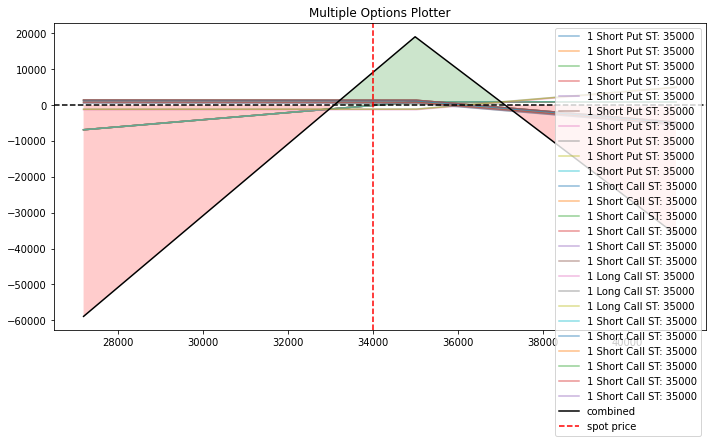

Stock Price : 35084
ubp : 37119.89444444444
lbp : 33092.095


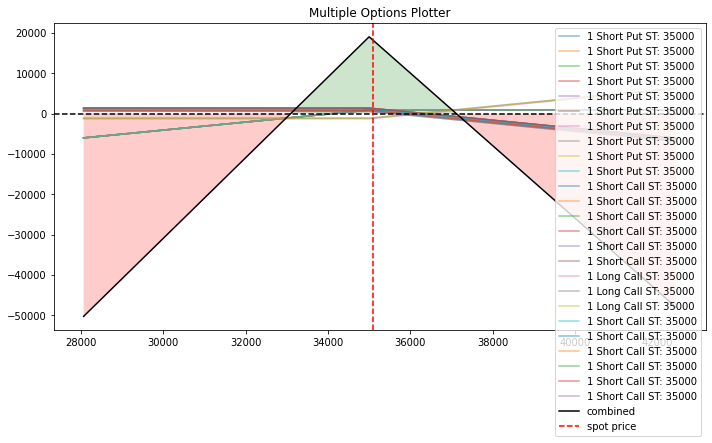

Stock Price : 34911
ubp : 37119.89444444444
lbp : 33092.095


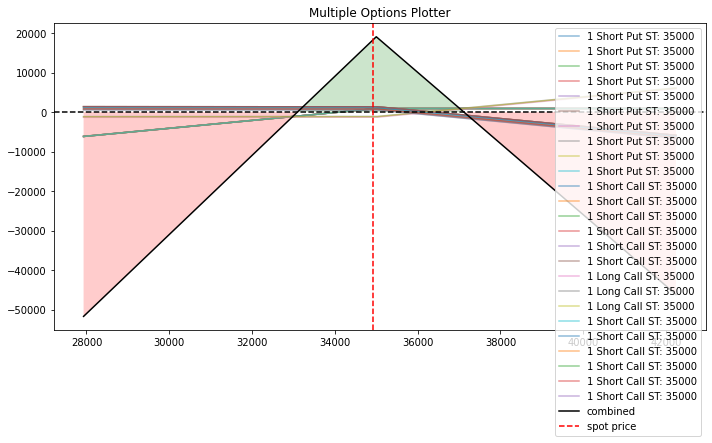

In [240]:
# RUNNING MY INVENTED ALGORITHM 

import opstrat as op 
op1={'op_type': 'c', 'strike': df['Strike Price'][0], 'tr_type': 's', 'op_pr': df['CE'][0]}
op2={'op_type': 'p', 'strike': df['Strike Price'][0], 'tr_type': 's', 'op_pr': df['PE'][0]}
# op_list=[op1, op2]
# op.multi_plotter(spot=df['Stock Price'][0], op_list=op_list) #,spot_range=10

op_list = []

for i in range(df['put_lot_size'][0]):
  op_list.append(op2)

for i in range(df['call_lot_size'][0]):
  op_list.append(op1)

# print(op_list)
# Upper Breakeven Point = Strike Price of Short Call + Net Premium Received
# Lower Breakeven Point = Strike Price of Short Put - Net Premium Received

################################
# npr = net premium received
# ubp = upper breakeven point 
# lbp = lower breakeven point 
################################
#number here refers to the number calls/puts sold 

#(ubp - strike )*number_calls = net_premium
number_puts = df['put_lot_size'][0]
number_calls = df['call_lot_size'][0]
print("number puts "+str(number_puts))
print("number calls "+str(number_calls))
npr = (df['PE'][0]*number_puts) + (df['CE'][0]*number_calls) 
ubp = df['Strike Price'][0] + (npr/number_calls)
lbp = df['Strike Price'][0] - (npr/number_puts)
# this commented one would only be true for equal calls and puts
# ubp = df['Strike Price'][0] + npr
# lbp = df['Strike Price'][0] - npr

#t_money is a variable to account for the buying/selling of calls during the algorithm is running 
t_money = 0 

# print(ubp)
# print(number_calls)
# if it hits the ubp we need to buy calls 
# if it hits the lbp we need to sell calls 

for i in range(0,len(df)):
  print("Stock Price : "+str(int(df['Stock Price'][i])))
  print("ubp : "+str(ubp))
  print("lbp : "+str(lbp))
  if(df['Stock Price'][i]>(ubp)):
    # buy a call 
    number_calls = number_calls-1
    t_money = t_money-df['CE'][i]  
    # make the new p/l graph 
    op3 = {'op_type': 'c', 'strike': df['Strike Price'][0], 'tr_type': 'b', 'op_pr': df['CE'][i]}
    op_list.append(op3)
    # code to shift ubp and lbp 
    npr = npr -df['CE'][i]  # + t_money 
    ubp = df['Strike Price'][0] + (npr/number_calls)
    lbp = df['Strike Price'][0] - (npr/number_puts)
    # op.multi_plotter(spot=df['Stock Price'][i], op_list=op_list)
  if(df['Stock Price'][i]<(lbp)):
    # sell a call 
    number_calls = number_calls+1
    t_money = t_money+df['CE'][i]
    # make the new p/l graph 
    op3 = {'op_type': 'c', 'strike': df['Strike Price'][0], 'tr_type': 's', 'op_pr': df['CE'][i]}
    op_list.append(op3)
    # op.multi_plotter(spot=df['Stock Price'][i], op_list=op_list) 
    # code to shift ubp and lbp 
    npr = npr +df['CE'][i] # + t_money 
    ubp = df['Strike Price'][0] + (npr/number_calls)
    lbp = df['Strike Price'][0] - (npr/number_puts)
  op.multi_plotter(spot=df['Stock Price'][i], op_list=op_list,save=True,file='simple_option'+str(i)+'.jpeg') 



In [241]:
# CALCULATING THE FINAL PROFITS 

# total profit variable only contains the step transaction costs for now
# final profit would be sum of - 
# the initial profits made by premiums of selling calls and puts 
# if we sell or buy calls to adjust the graph then their premiums need to be accounted for 
# at the expiry , sold calls and puts cancel each other , and need to calculate the loss from remaining lot 

final_profit = 0 #making the variable 
# money earned from selling initially 
final_profit = (df['put_lot_size'][0]*(df['PE'][0]))+(df['call_lot_size'][0]*(df['CE'][0]))
# print(final_profit)
# money from buying/selling calls during the algorithm 
final_profit = final_profit + t_money
# and the ending money 

if(number_calls > number_puts):
  if((df['Stock Price'][len(df)-1]) > df['Strike Price'][0]):
    final_profit = final_profit - (number_calls-number_puts)*(df['Strike Price'][0] - (df['Stock Price'][len(df)-1]) )

if(number_calls < number_puts):
  if((df['Stock Price'][len(df)-1]) < df['Strike Price'][0]):
    final_profit = final_profit - (number_puts-number_calls)*( (df['Stock Price'][len(df)-1]) - df['Strike Price'][0] )

print(final_profit)


19167.19844


In [242]:
# MAKING GIF AUTOMATICALLY OUT OF THE IMAGES 
from PIL import Image, ImageDraw
import imageio
images_data = []
for i in range(0,len(df)-1):
  data = imageio.imread('/content/simple_option'+str(i)+'.jpeg')
  images_data.append(data) #'simple_option'+str(i)+'.jpeg'

# print(images_data)
giffile = 'demo.gif'
imageio.mimwrite(giffile, images_data, format= '.gif', fps = 2)


In [242]:
# THANK YOU :) 